## Задание 1

Загружаю датасет

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np


# Set the path to the file you'd like to load
file_path = "googleplaystore.csv"

# Load the latest version
df: pd.DataFrame = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "lava18/google-play-store-apps",
  file_path,
)
print("First 5 records:", df.head())

/tmp/ipython-input-3913887976.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df: pd.DataFrame = kagglehub.load_dataset(


100%|██████████| 312k/312k [00:00<00:00, 47.1MB/s]

Extracting zip of googleplaystore.csv...
First 5 records:                                                  App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   Janua

Приведем колонки к типу int, где это возможно

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None


In [ ]:
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    if 'k' in size:
        return float(size.replace('k', '')) / 1024
    return np.nan


df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df['Size'] = df['Size'].apply(convert_size)
df['Installs'] = df['Installs'].str.replace(',', '').str.replace('+', '', regex=False).str.replace('Free', '0').astype(float)
df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace('$', '', regex=False), errors='coerce')


Проверяю на пропуски

In [ ]:
print(df.isna().sum())

App                  0
Category             0
Rating            1474
Reviews              1
Size              1696
Installs             0
Type                 1
Price                1
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


Пропуссков много, удалять нельзя, посмтрим гисторгамму по признакам и узнаем, чем их можно заполнить.

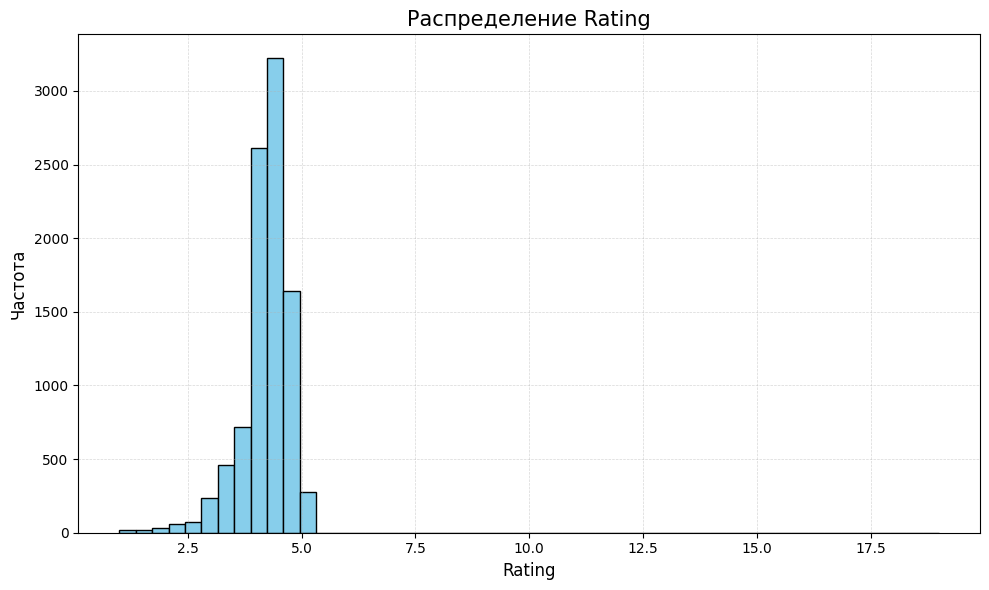

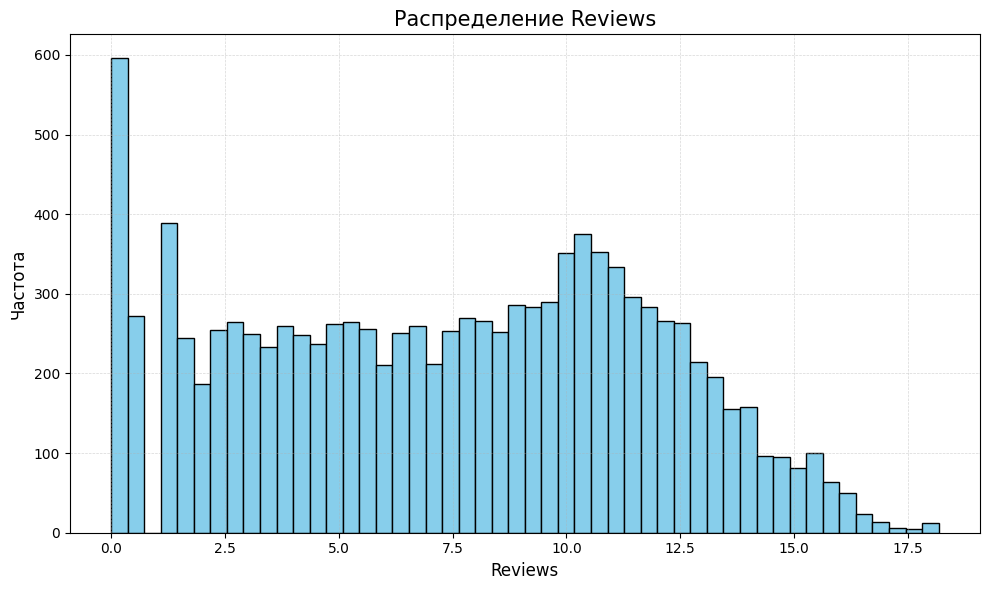

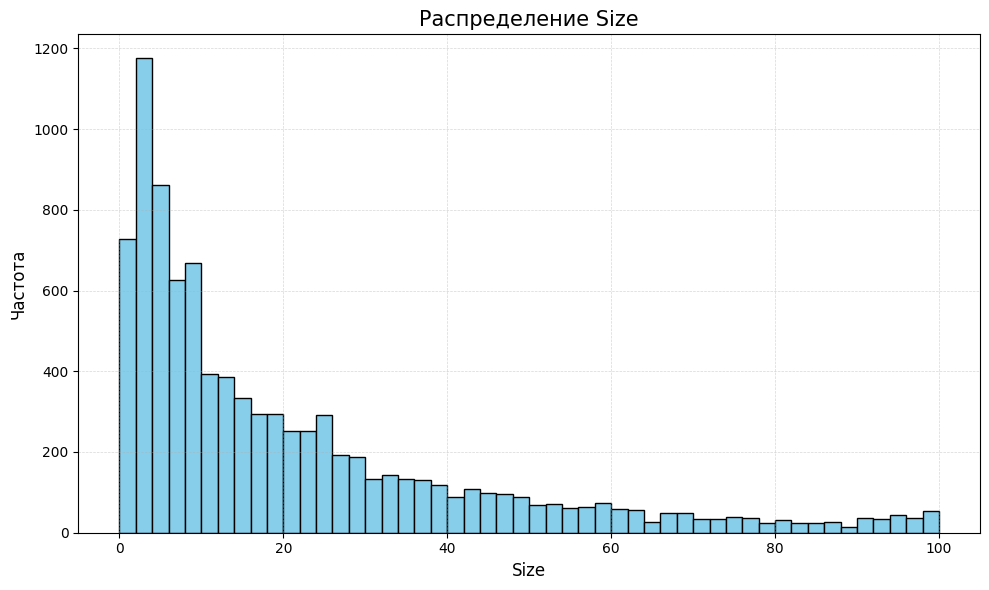

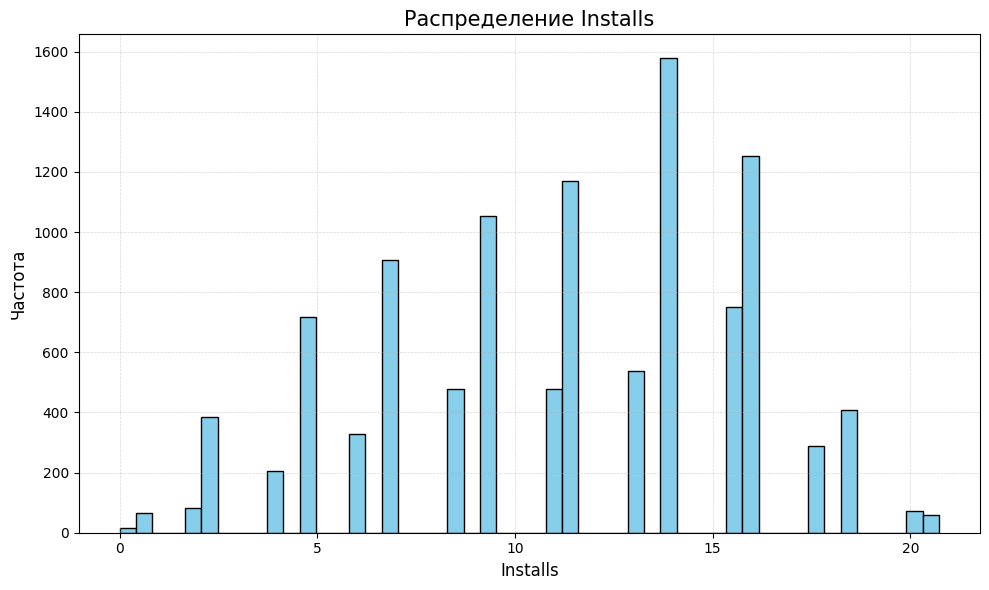

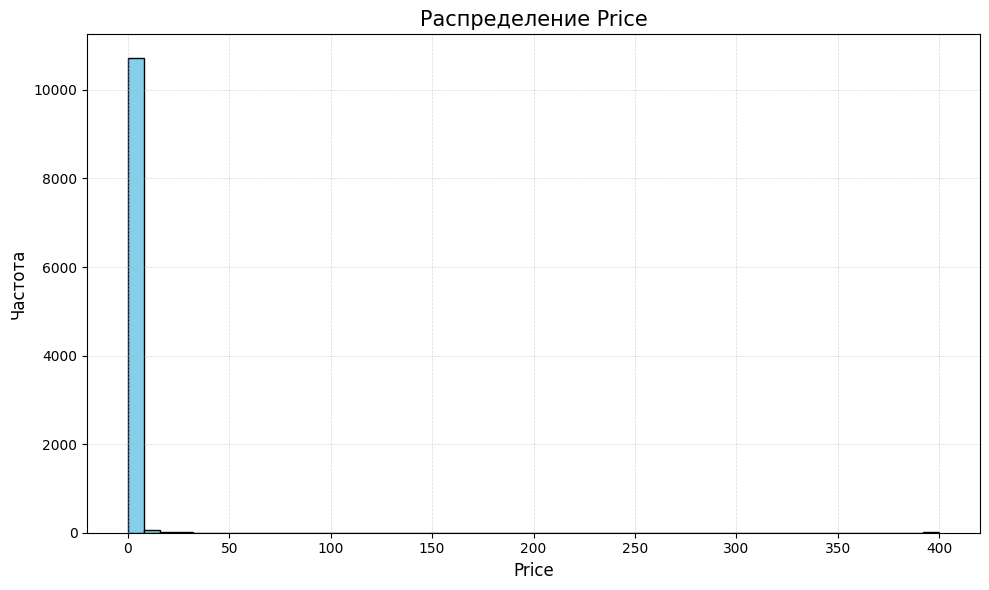

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


num_col = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']

def build_hist():
  df_copy = df.copy()
  for col in num_col:
    plt.figure(figsize=(10, 6))
    if col in ['Installs', 'Reviews', 'Price']:
      df_copy[col] = np.log1p(df_copy[col])

    plt.hist(df_copy[col], bins=50, color="skyblue", edgecolor="black")

    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

    plt.title(f"Распределение {col}", fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Частота", fontsize=12)

    plt.tight_layout()
    plt.show()


build_hist()

рейтинг лучше заполнить медианой

In [ ]:
rat_median = df['Rating'].median()
df['Rating'] = df['Rating'].fillna(rat_median)

В 'Reviews' сильный разброс и тяжелый правый хвост (много мелких, мало гигантов). Среднее будет смещено выбросами, поэтому заполняем медианой, она устойчивее.

In [ ]:
rev_median = df['Reviews'].median()
df['Reviews'] = df['Reviews'].fillna(rev_median)

Размер заполняем модой. Предполагаем, что пропуски не случайны и относятся к типовым приложениям стандартного размера

In [ ]:
size_mode = df['Size'].dropna().mode().tolist()[0]
df['Size'] = df['Size'].fillna(size_mode)

Цену заполняем модой (0), так как подавляющее большинство приложений бесплатны. Это наиболее вероятное значение для пропущенных данных

In [ ]:
price_mode = df['Price'].mode().tolist()[0]
df['Price'] = df['Price'].fillna(price_mode)

### 1.	Визуальный. Гистограмма

Строим новые графики

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    1
Genres            0
Last Updated      0
Current Ver       8
Android Ver       3
dtype: int64


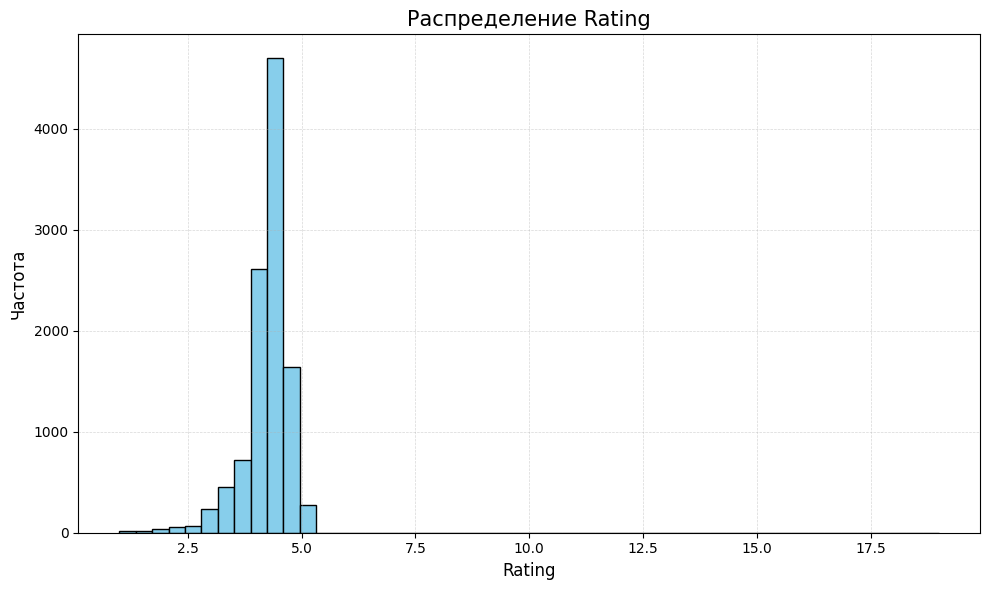

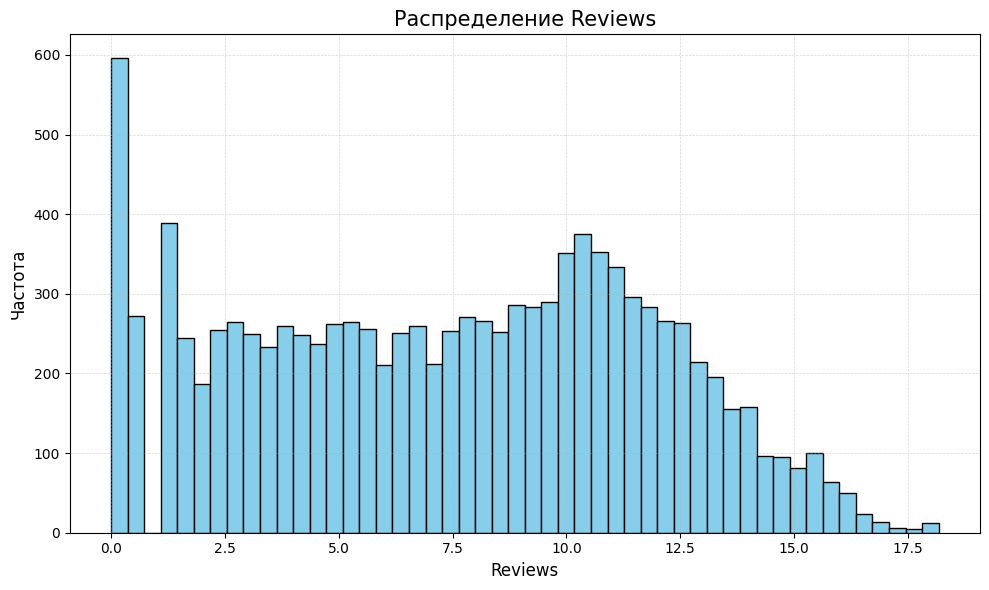

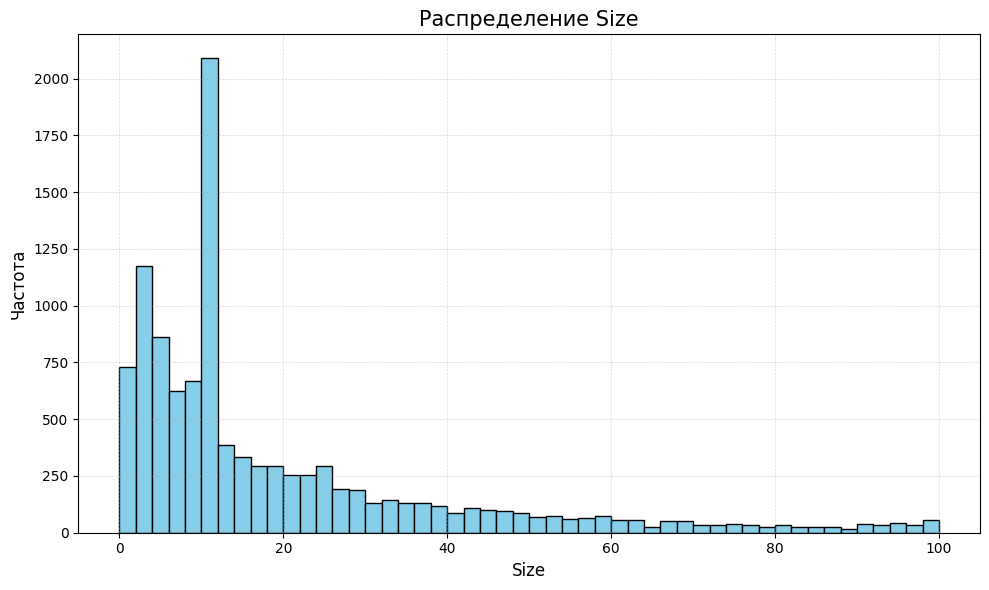

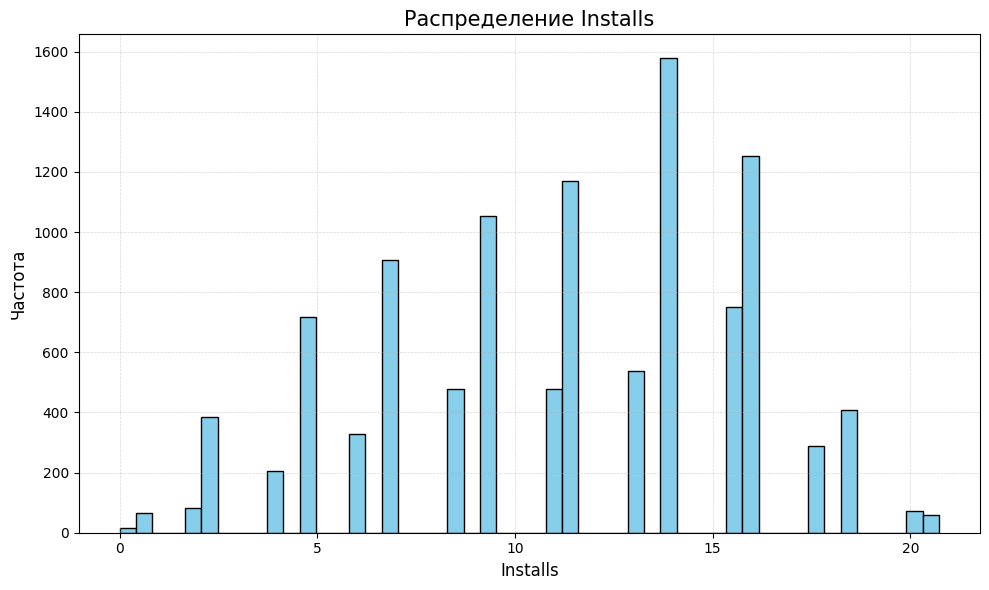

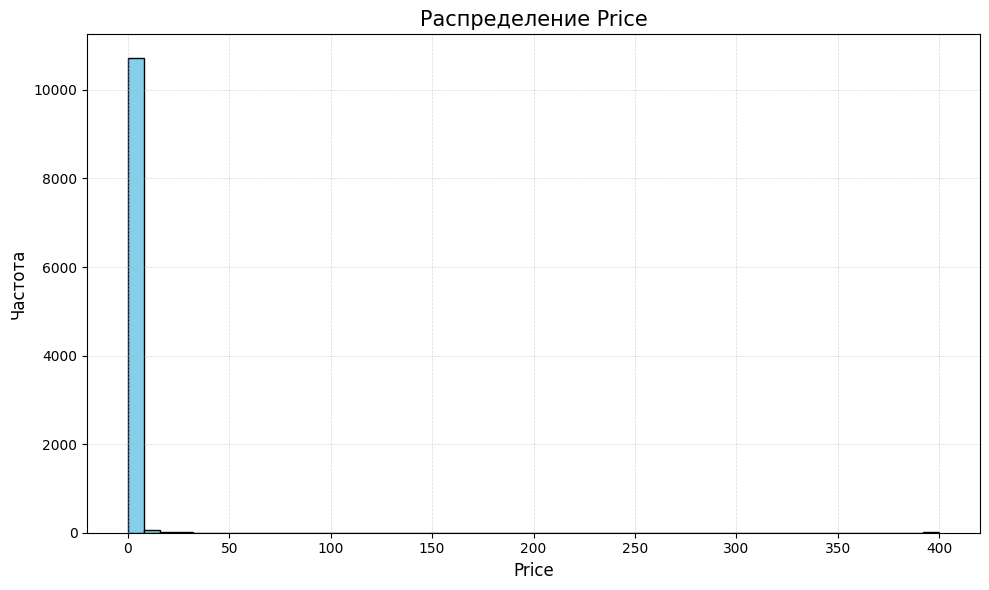

In [ ]:
print(df.isna().sum())
build_hist()

Смотря на гистограммы, можно увидеть, что данные распределены не нормально

### 2. Визуальный. График QQ-plot

Убедимся в этом, построив график QQ-plot

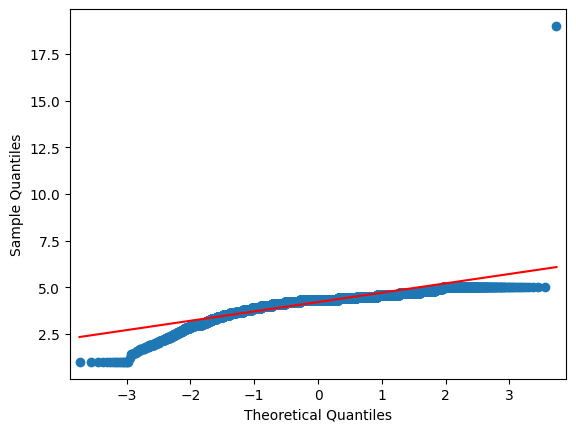

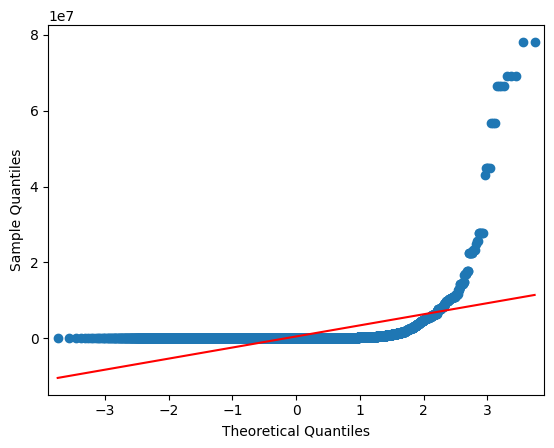

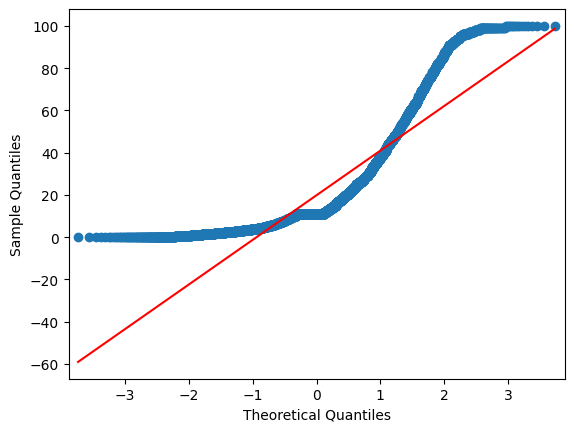

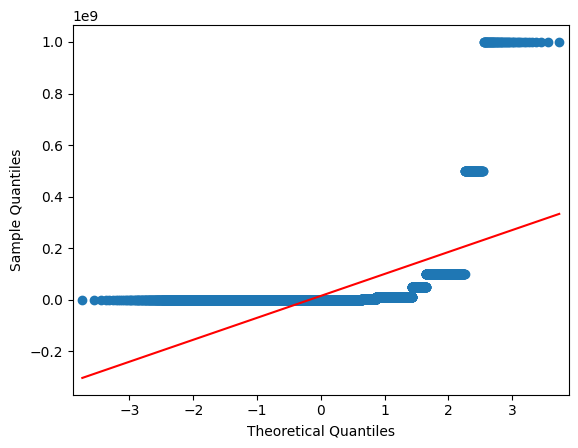

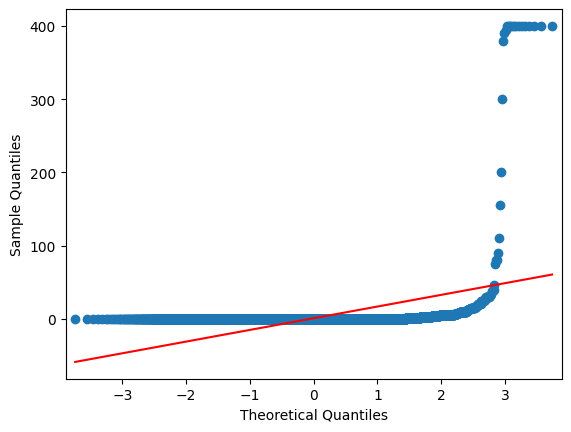

In [ ]:
import statsmodels.api as sm

for col in num_col:
  fig = sm.qqplot(df[col], line='s')

  plt.show()

Из этих графиков видно, что данные не нормальные

### 3. тест Шапиро-Уилка

Суть: Математически проверяет, насколько сильно данные коррелируют (совпадают) с прямой линией на QQ-plot. Считается самым мощным тестом для проверки именно нормальности.

Что показывает: Вероятность того, что выборка взята из нормального распределения ($p\text{-value}$).

- Идеал: $p > 0.05$ (нет доказательств ненормальности).

- Реальность: Если $p < 0.05$, то распределение гарантированно не нормальное.

Особенность: Очень строгий «учитель». На больших данных (N > 5000) придирается к мелочам и почти всегда отвергает нормальность.

Переходим к тесту Шапиро-Уилка, тут важно понимать, что он слишком чувствителен на больших выборках. У меня выборка на 10000 строк, что является большой.

In [ ]:
from scipy.stats import shapiro

for col in num_col:
  stat, p = shapiro(df[col])
  print(f'Для колонки {col}: \tstat={stat} \tp={p}')

Для колонки Rating: 	stat=0.7872093262086189, 	p=9.344785651017755e-80
Для колонки Reviews: 	stat=0.12475415646657562, 	p=4.639569932303767e-114
Для колонки Size: 	stat=0.7734150723374043, 	p=3.7958542937877713e-81
Для колонки Installs: 	stat=0.16080298794704362, 	p=5.980135805005397e-113
Для колонки Price: 	stat=0.0343640454259756, 	p=1.1236317765398623e-116


Можно заметить, что для всех числовых признаков чсло p всегда меньше 0.05, что говорит о том, что данные не нормальные. На это влияют 2 факторв:
1. Данные и вправду не нормальные
2. Как я уже и говорил, этот тест очень чувствителен к большой выборке

### 4. тест Колмогорова-Смирнова.


Суть: Строит две лестницы (кумулятивные функции — CDF): реальную и идеальную. Ищет максимальное вертикальное расстояние ($D$) между ними.

Что показывает: Насколько «сильно» данные отклоняются от эталона в самом худшем месте.

- Идеал: $D \to 0$ (лестницы сливаются), $p > 0.05$.

- Реальность: Менее чувствителен к хвостам, чем Шапиро, но хорошо ловит сдвиги центра.

Особенность: Универсальный солдат. Им можно проверять не только нормальность, но и равномерность, экспоненциальность и т.д.



Есть тонкий моент, что тест Колмогорова по умолчанию сравнивает данные со стандартным нормальным распределением (среднее = 0, отклонение = 1). То есть, елси провести тест просто так, то он покажет колосальное отклонение просто потому, что графики находятся в разных местах оси X.

Что бы избежать этого и сравнить нормально, нужно передать параметры распределения (среднее и отклонение) в аргумент **args**.

In [ ]:
from scipy.stats import kstest

for col in num_col:
  mean = df[col].mean()
  sigma = df[col].std()  # Стандартное отклонение

  stat, p = kstest(df[col], 'norm', args=(mean, sigma))
  print(f'Для колонки {col}: \tstat={stat} \tp={p}')

Для колонки Rating: 	stat=0.19175385548731416 	p=0.0
Для колонки Reviews: 	stat=0.4397130104306519 	p=0.0
Для колонки Size: 	stat=0.21275715468062562 	p=0.0
Для колонки Installs: 	stat=0.44923779110512946 	p=0.0
Для колонки Price: 	stat=0.47432188126261865 	p=0.0


Для всех признаков p < 0.05, что опять говорит о том, что данные не нормальные.

Важно:
- В Гистограммах я логарифмирую Installs, Reviews и Price, чтобы увидеть «хоть что-то похожее на колокол».
- В Тестах (Шапиро и КС) я скармливаю «сырые» данные (df[col]).

---

Вопрос: Почему тесты показывают такой катастрофический результат ($p \approx 0$)?

Ответ: Потому что сырые данные имеют экспоненциальное распределение (или Power Law), а я проверяю их на нормальное. Это как проверять, является ли квадрат кругом. Конечно, нет.

Эксперимент (мысленно):

Если бы ты подал в тест Шапиро прологарифмированные данные (те же, что идут в график), p-value всё равно, скорее всего, был бы меньше 0.05 (из-за огромной выборки), но статистика $W$ (в Шапиро) или $D$ (в КС) стала бы намного лучше.В реальном ML мы часто ищем такое преобразование $f(x)$ (лог, корень, Бокс-Кокс), при котором shapiro(f(x)) даст наилучший результат.

## Задание 2

В машинном обучении преобразование признаков называется Feature Engineering (конструирование признаков). Многие модели (например, Линейная регрессия, KNN) работают намного лучше, если данные имеют форму колокола, а не форму трамплина.

Пример с разбором ккаждого из методов от Gemini:

Представь, что у нас есть «хвостатый» признак, например, Reviews.X = [1, 10, 100, 1000, 10000]


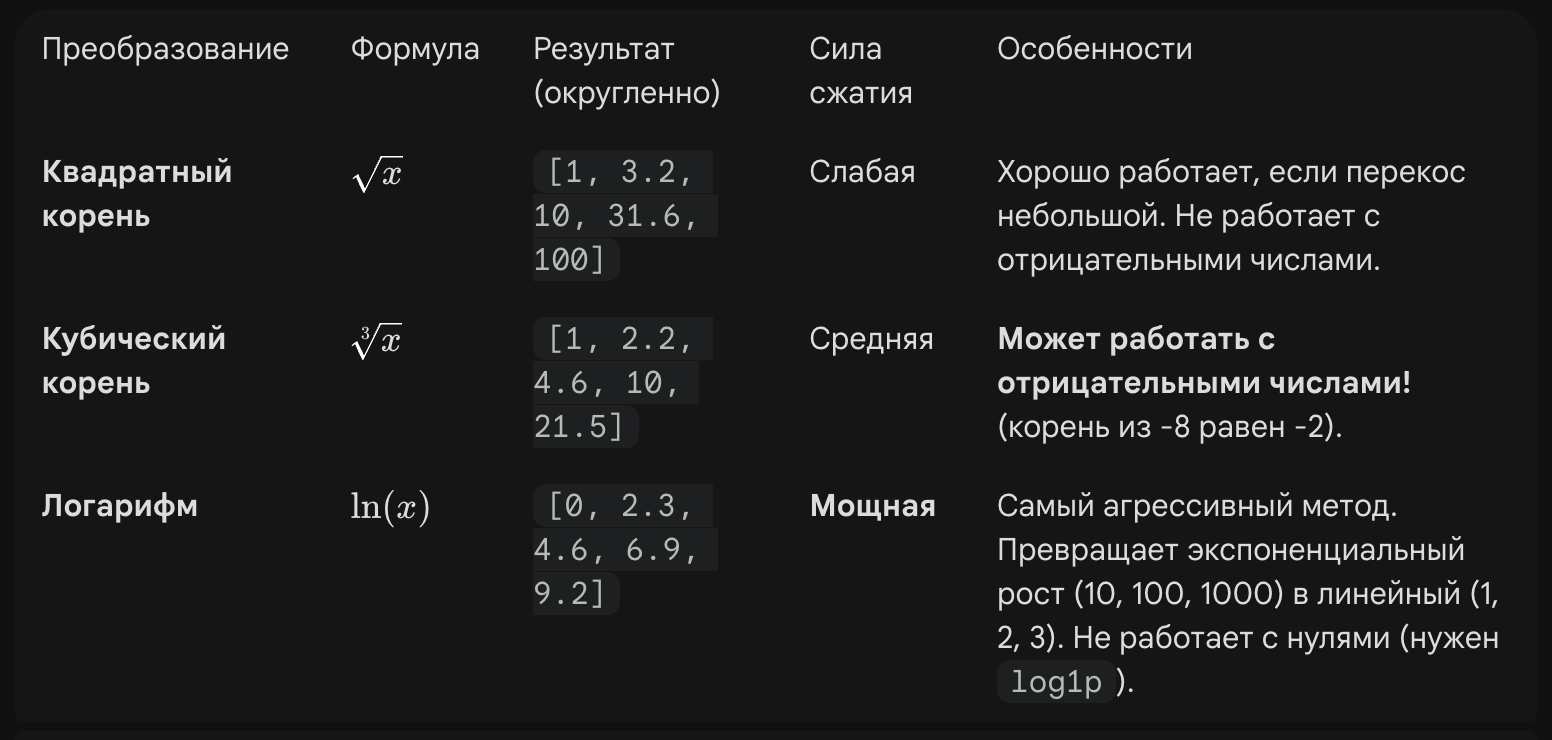


Вопрос: **Как выбрать «наиболее удачное»?**

В статистике есть понятие Коэффициент асимметрии (Skewness)
- Skewness = 0: Идеальная симметрия (Нормальное распределение).
- Skewness > 0: Хвост справа.
- Skewness < 0: Хвост слева.


Для признака Rating
Дефолный коэф асимметрии: 			0.5500768770713683
Логарифмический коэф асимметрии: 	-2.9117833026520064
Квадратный корень коэф асимметрии: 	-2.1045850522472405
Кубический корень коэф асимметрии: 	-2.6307773883449572


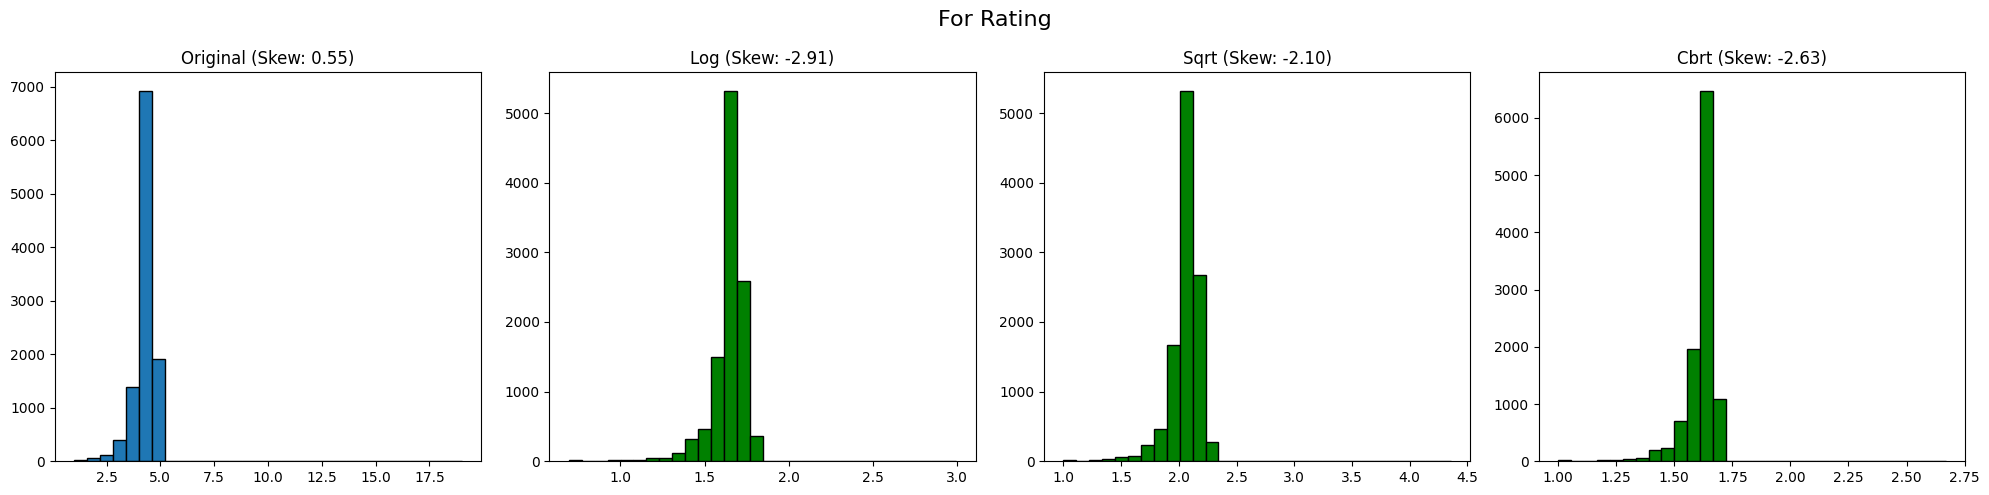




Для признака Reviews
Дефолный коэф асимметрии: 			16.45033243190058
Логарифмический коэф асимметрии: 	-0.015689723282327553
Квадратный корень коэф асимметрии: 	5.6877839505311885
Кубический корень коэф асимметрии: 	3.0968174317227137


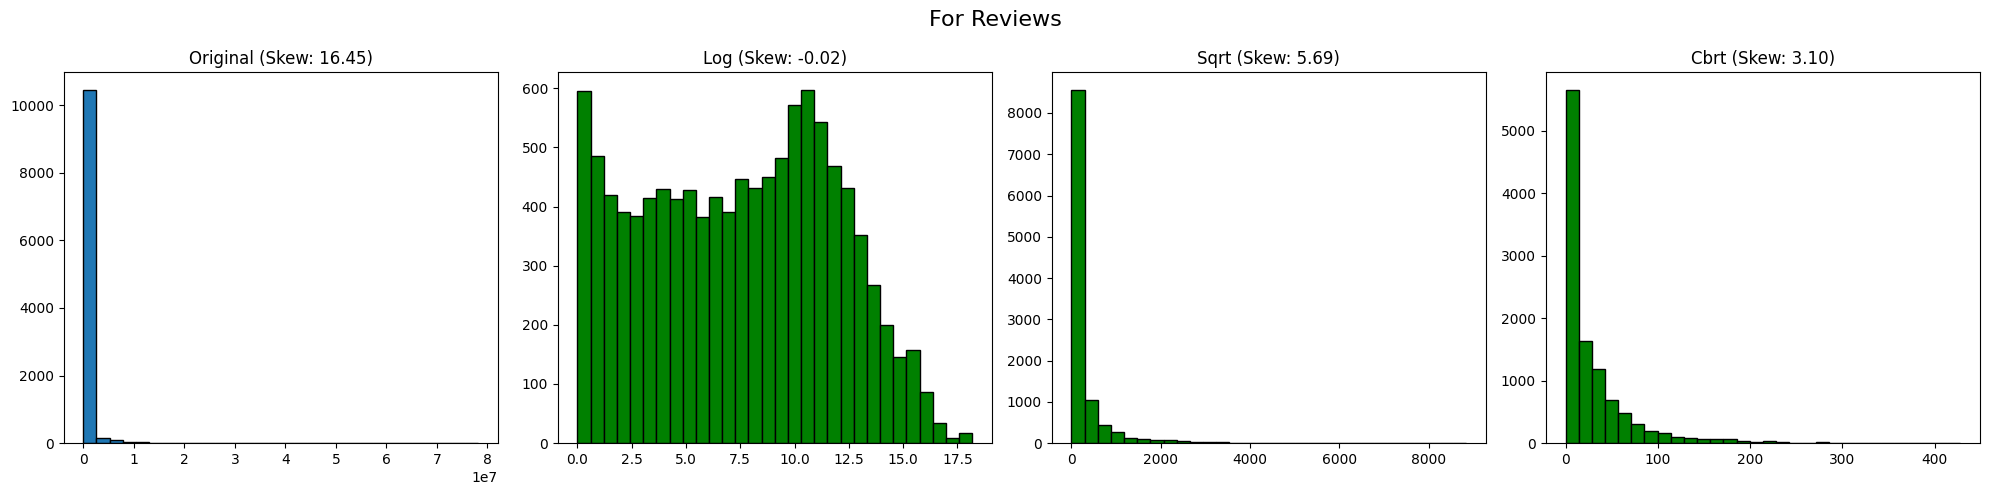




Для признака Size
Дефолный коэф асимметрии: 			1.827907253528092
Логарифмический коэф асимметрии: 	-0.08160146889634454
Квадратный корень коэф асимметрии: 	0.8860569300355374
Кубический корень коэф асимметрии: 	0.46788377579894935


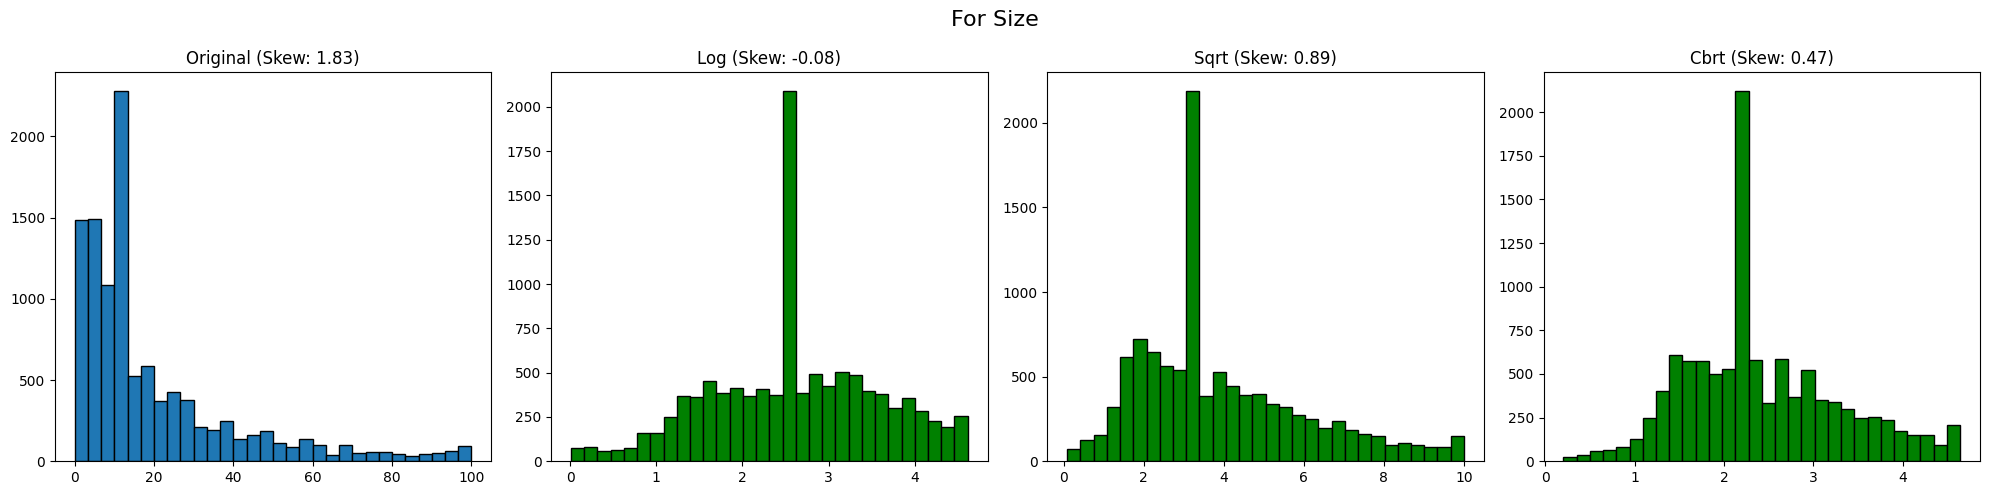




Для признака Installs
Дефолный коэф асимметрии: 			9.572514109668411
Логарифмический коэф асимметрии: 	-0.30422762705062606
Квадратный корень коэф асимметрии: 	5.000653295148574
Кубический корень коэф асимметрии: 	2.876813082259185


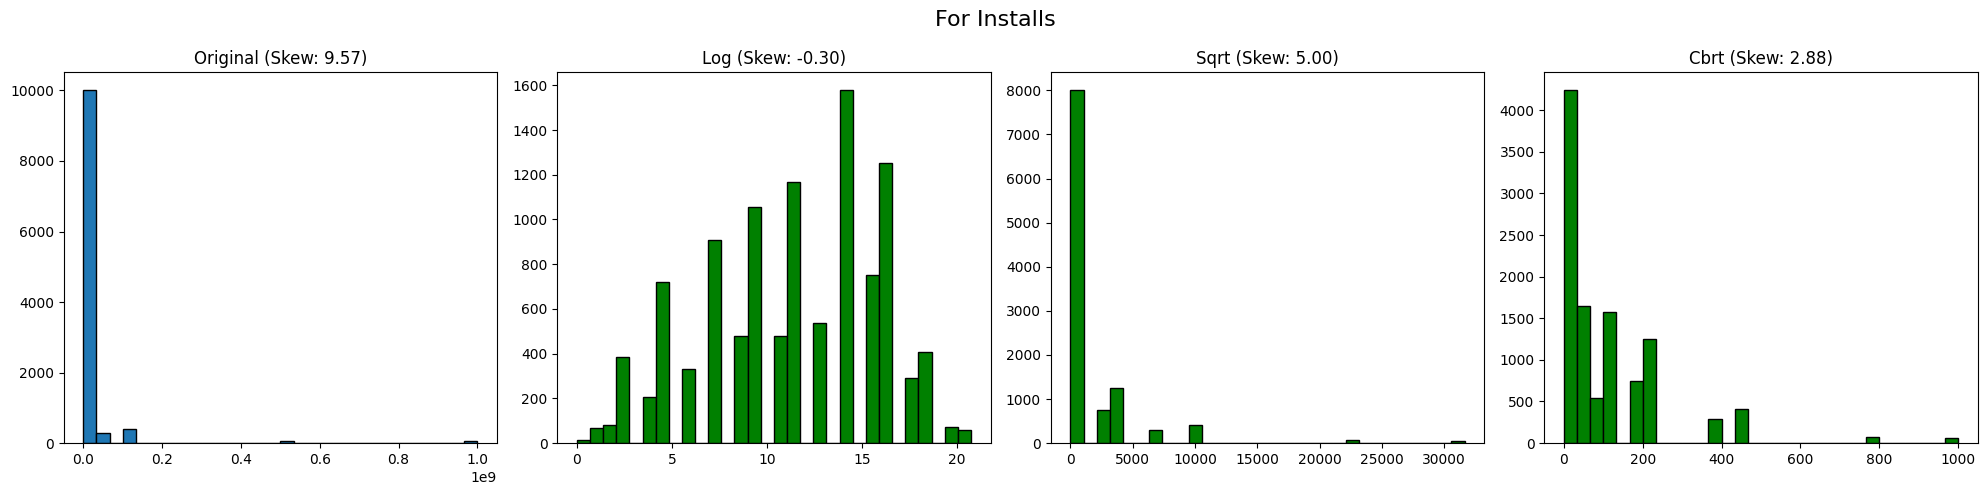




Для признака Price
Дефолный коэф асимметрии: 			23.708489758783823
Логарифмический коэф асимметрии: 	5.857672661405746
Квадратный корень коэф асимметрии: 	13.609478121239821
Кубический корень коэф асимметрии: 	6.750009676779071


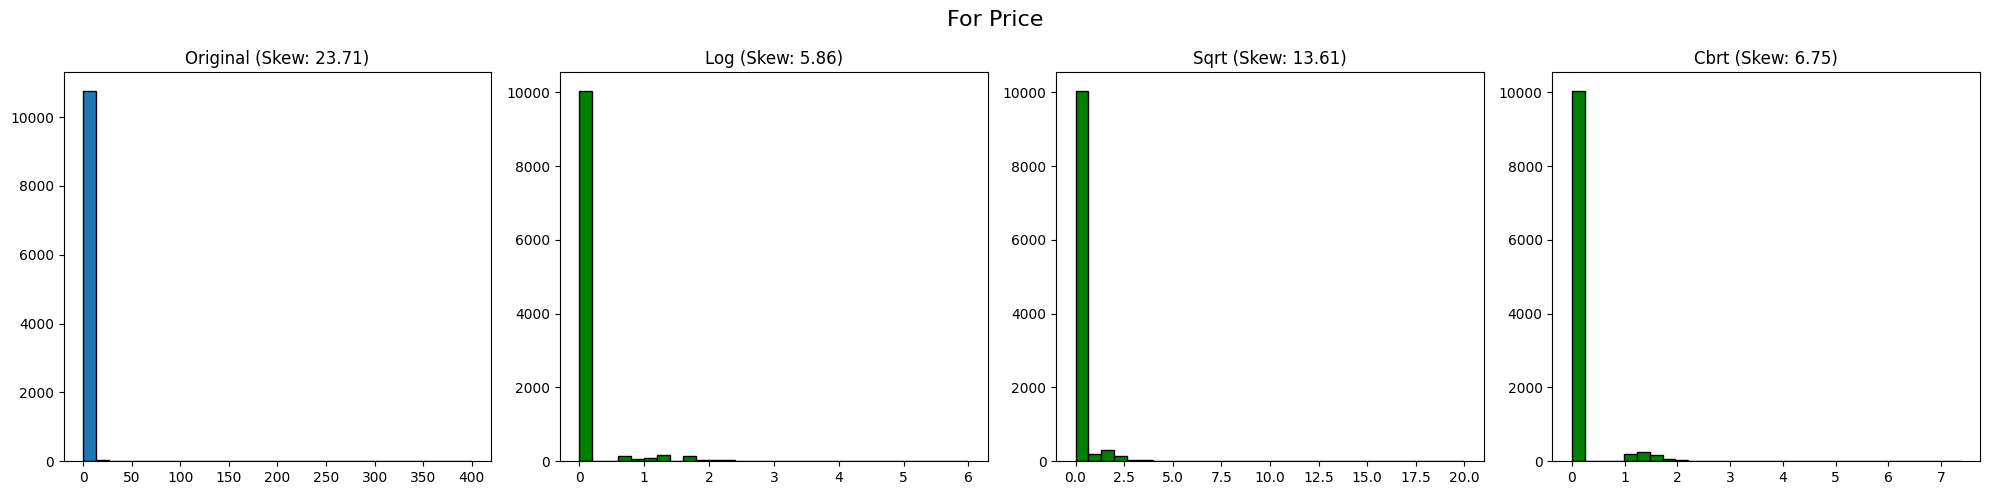

In [ ]:

for col in num_col:
  default_skew = df[col].skew()
  log_skew = np.log1p(df[col]).skew()
  sqrt2_skew = np.sqrt(df[col]).skew()
  cbrt_skew = np.cbrt(df[col]).skew()

  print(f'Для признака {col}')
  print(f'Дефолный коэф асимметрии: \t\t\t{default_skew}')
  print(f'Логарифмический коэф асимметрии: \t{log_skew}')
  print(f'Квадратный корень коэф асимметрии: \t{sqrt2_skew}')
  print(f'Кубический корень коэф асимметрии: \t{cbrt_skew}')

  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

  fig.suptitle(f'For: {col}', fontsize=16)
  plt.subplots_adjust(top=0.85)

  # default
  axs[0].hist(df[col], bins=30, edgecolor='black')
  axs[0].set_title(f'Original (Skew: {default_skew:.2f})')

  # log
  axs[1].hist(np.log1p(df[col]), bins=30, color='green', edgecolor='black')
  axs[1].set_title(f'Log (Skew: {log_skew:.2f})')

  # sqrt
  axs[2].hist(np.sqrt(df[col]), bins=30, color='green', edgecolor='black')
  axs[2].set_title(f'Sqrt (Skew: {sqrt2_skew:.2f})')

  # cbrt
  axs[3].hist(np.cbrt(df[col]), bins=30, color='green', edgecolor='black')
  axs[3].set_title(f'Cbrt (Skew: {cbrt_skew:.2f})')

  plt.tight_layout()
  plt.show()
  print('\n\n')



Рассмотрим каждый признак и выявим лучший коэф:
- Rating – для рейтигп лучше всего оказывается ничего не делать, тк его оригинальный коэф асимметрии ближе всего к нулю.
- Reviews – для отзываов, ближе всего к нулю оказалось логарифмический коэффициент асимметрии. Хоть он и меньше 0, но ближе всего к нему.
- Size – для размера, ближе всего к нулю оказалось логарифмический коэффициент асимметрии. Хоть он и меньше 0, но ближе всего к нему.
- Installs – для загрузок, ближе всего к нулю оказалось логарифмический коэффициент асимметрии. Хоть он и меньше 0, но ближе всего к нему.
- Price – для цены все коэф больше 0, даже больше 5 (из за огромного кл-ва 0), но самый минимальный из них – это логарифмический коэффициент асимметрии

---

Примечания:

Логарифм, Корень и Куб. корень предназначены для правосторонней асимметрии (когда хвост уходит в большие числа, как у зарплат или кол-ва отзывов).Они «сжимают» гигантов.